## Importação da Biblioteca do Google Earth Engine


In [ ]:
import ee 

ee.Authenticate()   # abre o browser p/ login
ee.Initialize(project='')     # conecta sua sessão

### Colocando as coordenadas do poligono selecionado no site : https://code.earthengine.google.com/

In [2]:
coords = [ [-50.371698, -24.54722],
    [-50.371551, -24.546964],
    [-50.371269, -24.546342],
    [-50.371000, -24.545605],
    [-50.370823, -24.544800],
    [-50.370753, -24.544142],
    [-50.370780, -24.543439],
    [-50.370884, -24.542887],
    [-50.371125, -24.542346],
    [-50.371382, -24.541970],
    [-50.371731, -24.541594],
    [-50.372015, -24.541365],
    [-50.372402, -24.541145],
    [-50.374142, -24.540278],
    [-50.374710, -24.539985],
    [-50.375627, -24.539502],
    [-50.375799, -24.539454],
    [-50.375851, -24.539563],
    [-50.376208, -24.540466],
    [-50.376729, -24.541700],
    [-50.376810, -24.541878],
    [-50.371698, -24.547220]  # fecha o anel (mesmo do primeiro ponto)
]

    
aoi = ee.Geometry.Polygon(coords) 

### Selecionando o Satélite --> O intervalo de Tempo -> Filtrando o Resultado 

In [3]:
S2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

start = '2024-05-01' 
end = '2024-05-31'

s2_sel = (S2
    .filterDate(start, end)
    .filterBounds(aoi)      
    .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 20)))

print('Imagens filtradas:', s2_sel.size().getInfo())


Imagens filtradas: 2


### Selecionando a melhor imagem de acordo com o filtro -> Pegando todas as bandas que serão utilizadas para os cálculos dos índices.

In [4]:
best = s2_sel.sort('CLOUDY_PIXEL_PERCENTAGE').first()

nir = best.select('B8').toFloat().divide(10000) # seleciona INFRAVERMELHO
red = best.select('B4').toFloat().divide(10000) # seleciona RED 
blue = best.select('B2').toFloat().divide(10000) # seleciona AZUL
green = best.select('B3').toFloat().divide(10000) # seleciona o VERDE
swir1 = best.select('B11').toFloat().divide(10000) 
re1 = best.select('B5').toFloat().divide(10000) # seleciona o red-edge
re2 = best.select('B6').toFloat().divide(10000)  # red-edge 2

### NDVI : mede o vigor da vegetação comparando infravermelho (NIR) e vermelho (RED).

In [5]:
ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

stats = ndvi.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), sharedInputs=True),
    geometry=aoi,
    scale=10,            # Sentinel-2 em 10 m para B4/B8
    maxPixels=1e9,
    bestEffort=True
)

print('NDVI stats:', stats.getInfo())

NDVI stats: {'NDVI_max': 0.8291243804578711, 'NDVI_mean': 0.3598313093467725, 'NDVI_min': 0.08901098901098897}


### EVI → realça o vigor em áreas densas, corrigindo saturação e influência atmosférica.

In [6]:
evi = nir.subtract(red).multiply(2.5) \
        .divide(nir.add(red.multiply(6)).subtract(blue.multiply(7.5)).add(1)) \
        .rename('EVI')

evi_stats = evi.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), sharedInputs=True),
    geometry=aoi,
    scale=10,
    maxPixels=1e9,
    bestEffort=True
)
print('EVI stats:', evi_stats.getInfo())

EVI stats: {'EVI_max': 0.6470544810276097, 'EVI_mean': 0.22757094296710217, 'EVI_min': 0.04455445544554453}


### NDWI → indica presença de água em superfícies (vegetação ou solo).

In [7]:
ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')

ndwi_stats = ndwi.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), sharedInputs=True),
    geometry=aoi, scale=10, maxPixels=1e9, bestEffort=True
)
print('NDWI stats:', ndwi_stats.getInfo())

NDWI stats: {'NDWI_max': -0.32695276319851807, 'NDWI_mean': -0.47834762768675443, 'NDWI_min': -0.7545845596558751}


### NDMI → mede o teor de umidade da vegetação (NIR vs SWIR1).

In [8]:


ndmi = nir.subtract(swir1).divide(nir.add(swir1)).rename('NDMI')

ndmi_stats = ndmi.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), sharedInputs=True),
    geometry=aoi, scale=10, maxPixels=1e9, bestEffort=True
)
print('NDMI stats:', ndmi_stats.getInfo())


NDMI stats: {'NDMI_max': 0.2790889585740221, 'NDMI_mean': -0.14939806647644754, 'NDMI_min': -0.31825410849973496}


### GNDVI → sensível à clorofila, usa o verde (GREEN) em vez do vermelho.

In [9]:
gndvi = nir.subtract(green).divide(nir.add(green)).rename('GNDVI')

gndvi_stats = gndvi.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), sharedInputs=True),
    geometry=aoi, scale=10, maxPixels=1e9, bestEffort=True
)
print('GNDVI stats:', gndvi_stats.getInfo())


GNDVI stats: {'GNDVI_max': 0.7545845596558751, 'GNDVI_mean': 0.47834762768675443, 'GNDVI_min': 0.32695276319851807}


### NDRE → detecta clorofila em plantas mais densas usando a banda red-edge.

In [10]:
ndre = nir.subtract(re1).divide(nir.add(re1)).rename('NDRE')

ndre_stats = ndre.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), sharedInputs=True),
    geometry=aoi, scale=10, maxPixels=1e9, bestEffort=True
)
print('NDRE stats:', ndre_stats.getInfo())

NDRE stats: {'NDRE_max': 0.5962924819773429, 'NDRE_mean': 0.23071779958523625, 'NDRE_min': 0.03402854006586175}


### RENDVI → variação do NDVI baseada em bandas red-edge (maior precisão em vegetação vigorosa).

In [11]:
rendvi = nir.subtract(re2).divide(nir.add(re2)).rename('RENDVI_A')

rendvi_stats = rendvi.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), sharedInputs=True),
    geometry=aoi, scale=10, maxPixels=1e9, bestEffort=True
)
print('RENDVI stats:', rendvi_stats.getInfo())


RENDVI stats: {'RENDVI_A_max': 0.1839501648955661, 'RENDVI_A_mean': 0.07995856802689913, 'RENDVI_A_min': -0.02937915742793791}


### BIOMASSA → combinação de NDVI e NDRE para estimar o vigor e a quantidade de matéria vegetal.

In [12]:
# Normalização min-max dentro da AOI (simples, só p/ proxy)
def minmax(img_band, name):
    stats = img_band.reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=aoi, scale=10, maxPixels=1e9, bestEffort=True
    )
    mn = ee.Number(stats.get(name + '_min'))
    mx = ee.Number(stats.get(name + '_max'))
    # evita divisão por zero
    norm = img_band.subtract(mn).divide(mx.subtract(mn).max(1e-6)).rename(name + '_norm')
    return norm

ndvi_norm = minmax(ndvi.rename('NDVI'), 'NDVI')
ndre_norm = minmax(ndre.rename('NDRE'), 'NDRE')

biomassa_proxy = ndvi_norm.add(ndre_norm).divide(2).rename('BIOMASSA_PROXY')  # 0..1
biomassa_score = biomassa_proxy.multiply(100).rename('BIOMASSA_SCORE')        # 0..100

# Estatística pra validar
bio_stats = biomassa_score.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), sharedInputs=True),
    geometry=aoi, scale=10, maxPixels=1e9, bestEffort=True
)
print('BIOMASSA proxy stats:', bio_stats.getInfo())


BIOMASSA proxy stats: {'BIOMASSA_SCORE_max': 100, 'BIOMASSA_SCORE_mean': 35.78669670263209, 'BIOMASSA_SCORE_min': 2.2496572680127422}


### SIMULAÇÃO DO CÁLCULO DE NDVI ANTES E DEPOIS

In [13]:
antes_start, antes_end   = '2024-05-01', '2024-05-31'
depois_start, depois_end = '2024-10-01', '2024-10-31'

def period_composite(start, end):
    S2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
          .filterDate(start, end)
          .filterBounds(aoi)
          .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 40)))
    cleaned = S2.map(mask_s2_clouds)          # se quiser, depois acrescente a máscara SCL
    comp = cleaned.median()                    # compósito temporal
    return comp


def mask_s2_clouds(image):
    qa = image.select('QA60')
    cloud_bit = 1 << 10
    cirrus_bit = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit).eq(0).And(qa.bitwiseAnd(cirrus_bit).eq(0))
    return image.updateMask(mask).copyProperties(image, ['system:time_start'])

def ndvi_from(start, end):
    img = period_composite(start, end)
    nir = img.select('B8').toFloat().divide(10000)
    red = img.select('B4').toFloat().divide(10000)
    return nir.subtract(red).divide(nir.add(red)).rename('NDVI')


ndvi_antes  = ndvi_from(antes_start, antes_end)
ndvi_depois = ndvi_from(depois_start, depois_end)

delta_ndvi = ndvi_depois.subtract(ndvi_antes).rename('DELTA_NDVI')  # depois - antes

delta_stats = delta_ndvi.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), sharedInputs=True),
    geometry=aoi, scale=10, maxPixels=1e9, bestEffort=True
)
print('ΔNDVI stats:', delta_stats.getInfo())


ΔNDVI stats: {'DELTA_NDVI_max': 0.18513728709271823, 'DELTA_NDVI_mean': -0.19085340561180394, 'DELTA_NDVI_min': -0.703056394691494}


### Gráfico simples que demonstra a mudança do NDVI nessa região




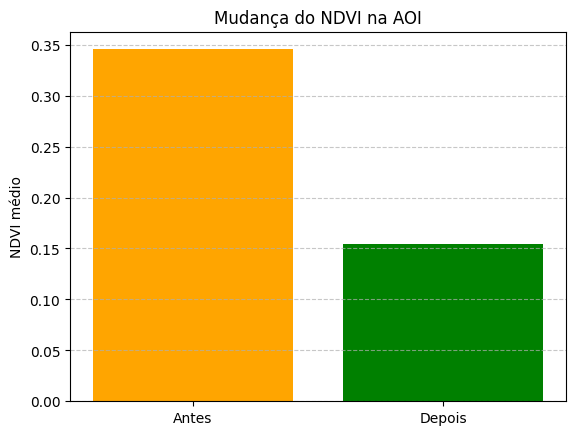

In [14]:
import matplotlib.pyplot as plt

# Extrai os valores médios de NDVI antes e depois
stats_before = ndvi_antes.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi, scale=10, maxPixels=1e9, bestEffort=True
).getInfo()

stats_after = ndvi_depois.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi, scale=10, maxPixels=1e9, bestEffort=True
).getInfo()

mean_before = stats_before['NDVI']
mean_after  = stats_after['NDVI']

# Plot simples
plt.bar(['Antes', 'Depois'], [mean_before, mean_after], color=['orange', 'green'])
plt.ylabel('NDVI médio')
plt.title('Mudança do NDVI na AOI')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Teor de Argila no solo

In [15]:
SCALE = 250               # resolução nativa do OpenLandMap (~250 m)
REGION = aoi         
DEPTH = '0-5cm'           # '0-5cm' | '5-15cm' | '15-30cm' | '30-60cm' | '60-100cm' | '100-200cm'

DEPTH_TO_BAND = {
    '0-5cm':     'b0',
    '5-15cm':    'b10',
    '15-30cm':   'b30',
    '30-60cm':   'b60',
    '60-100cm':  'b100',
    '100-200cm': 'b200',
}

def get_clay_image(depth_label: str) -> ee.Image:
    """Retorna imagem (% argila) para a profundidade desejada, renomeada para 'clay_pct'."""
    band = DEPTH_TO_BAND[depth_label]
    img = (ee.Image('OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02')
           .select(band)
           .rename('clay_pct'))
    return img


In [16]:
def clay_stats(image: ee.Image, region: ee.Geometry, scale: int = 250) -> dict:
    """Calcula mean/min/max do teor de argila (%) na região."""
    r = image.reduceRegion(
        reducer=ee.Reducer.mean().combine(reducer2=ee.Reducer.min(), sharedInputs=True)
                               .combine(reducer2=ee.Reducer.max(), sharedInputs=True),
        geometry=region,
        scale=scale,
        maxPixels=1e13,
        bestEffort=True
    )
    # getInfo é ok para um dicionário pequeno de stats
    d = r.getInfo()
    # padroniza chaves
    val_mean = d.get('clay_pct_mean')
    val_min  = d.get('clay_pct_min')
    val_max  = d.get('clay_pct_max')
    stats = {
        'CLAY_mean_%': val_mean,
        'CLAY_min_%':  val_min,
        'CLAY_max_%':  val_max
    }
    print(f"ARGILA ({SCALE} m, {DEPTH}) stats:", stats)
    return stats

# --- rodar ---
clay_img = get_clay_image(DEPTH)
_ = clay_stats(clay_img, REGION, SCALE)


ARGILA (250 m, 0-5cm) stats: {'CLAY_mean_%': 37.89171452009845, 'CLAY_min_%': 32, 'CLAY_max_%': 43}
